# Data Exploration, Parsing and Splitting

## Mount Google Drive for Content

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
DATA_DIR = "/content/drive/MyDrive/neural-re-data"
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")

## Parse Raw Data

Extract raw data provided in a combination of `.txt` and `.ann` files into a consolidated SpaCy like input format.

In [ ]:
def parse_text(file_path):
  with open(file_path, "r") as ftxt:
    text = ftxt.read()
  return text

def parse_entity_and_relation(file_path, text):
  entity_dict, recs = {}, []
  with open(file_path, "r") as fann:
    for line in fann:
      line = line.strip()
      if line.startswith("T"):
        # entities
        eid, etype_grp, espan = line.split("\t")
        etype, estart, eend = etype_grp.split()
        estart = int(estart)
        eend = int(eend)
        entity_dict[eid] = (etype, estart, eend, espan)
      elif line.startswith("R"):
        # relations
        rid, rgrp = line.split("\t")
        rtype, rsub_grp, robj_grp = rgrp.split()
        if rsub_grp.startswith("Arg1"):
          rsub_type, rsub_start, rsub_end, _ = entity_dict[rsub_grp.split(":")[1]]
          robj_type, robj_start, robj_end, _ = entity_dict[robj_grp.split(":")[1]]
        else:
          rsub_type, rsub_start, rsub_end, _ = entity_dict[robj_grp.split(":")[1]]
          robj_type, robj_start, robj_end, _ = entity_dict[rsub_grp.split(":")[1]]
        
        # print(text[rsub_start : rsub_end], rtype, text[robj_start : robj_end])
        rec = {
          "text": text,
          "h": {
            "type": rsub_type,
            "start": rsub_start,
            "end": rsub_end,
            "span": text[rsub_start : rsub_end],
          },
          "t": {
            "type": robj_type,
            "start": robj_start,
            "end": robj_end,
            "span": text[robj_start : robj_end],
          },
          "r": rtype
        }
        recs.append(rec)
      else:
        pass
  return recs

In [ ]:
txt_files = [fn for fn in os.listdir(os.path.join(DATA_DIR, "raw_data")) if fn.endswith(".txt")]
ann_files = [fn.replace(".txt", ".ann") for fn in txt_files]

for txt_file, ann_file in zip(txt_files, ann_files):
  text = parse_text(os.path.join(RAW_DATA_DIR, txt_file))
  recs = parse_entity_and_relation(os.path.join(RAW_DATA_DIR, ann_file), text)
  print("number of entries:", len(recs))
  print(json.dumps(recs[0], indent=2))
  break

number of entries: 19
{
  "text": "Background maintenance is a frequent element of video surveillance systems. We develop Wallflower, a three-component system for background maintenance: the pixel-level component performs Wiener filtering to make probabilistic predictions of the expected background; the region-level component fills in homogeneous regions of foreground objects; and the frame-level component detects sudden, global changes in the image and swaps in better approximations of the background. We compare our system with 8 other background subtraction algorithms. Wallflower is shown to outperform previous algorithms by handling a greater set of the difficult situations that can occur. Finally, we analyze the experimental results and propose normative principles for background maintenance.",
  "h": {
    "type": "Task",
    "start": 0,
    "end": 22,
    "span": "Background maintenance"
  },
  "t": {
    "type": "Task",
    "start": 48,
    "end": 74,
    "span": "video surveill

## Basic Counts

In [ ]:
entity_counter = collections.Counter()
relation_counter = collections.Counter()
for txt_file, ann_file in zip(txt_files, ann_files):
  text = parse_text(os.path.join(RAW_DATA_DIR, txt_file))
  recs = parse_entity_and_relation(os.path.join(RAW_DATA_DIR, ann_file), text)
  for rec in recs:
    entity_counter[rec["h"]["type"]] += 1
    entity_counter[rec["t"]["type"]] += 1
    relation_counter[rec["r"]] += 1

In [ ]:
ent_df = pd.DataFrame(entity_counter.most_common(len(entity_counter)),
                      columns=["etype", "count"])
ent_df.head(len(entity_counter))

,etype,count
0,Method,3739
1,Generic,3021
2,OtherScientificTerm,2496
3,Task,2037
4,Material,991
5,Metric,504


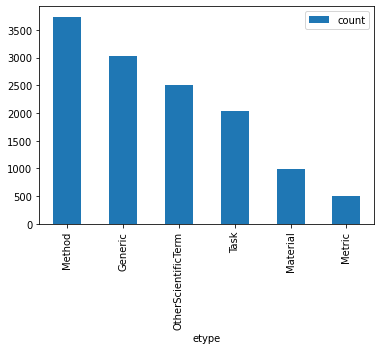

In [ ]:
_ = ent_df.plot.bar(x="etype", y="count", rot=90)

In [ ]:
rel_df = pd.DataFrame(relation_counter.most_common(len(relation_counter)),
                      columns=["rtype", "count"])
rel_df.head(len(relation_counter))

,rtype,count
0,USED-FOR,2437
1,COREF,1675
2,CONJUNCTION,583
3,HYPONYM-OF,477
4,EVALUATE-FOR,454
5,PART-OF,270
6,FEATURE-OF,264
7,COMPARE,234


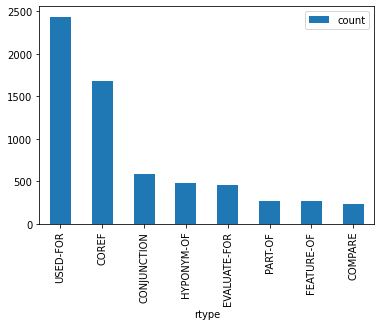

In [ ]:
_ = rel_df.plot.bar(x="rtype", y="count", rot=90)

## Text (Token) Lengths

BERT and BERT-like models allow a maximum token length of 512 tokens, and our maximum token size is 316. So we won't have to drop anything even considering sub-word tokenization, standard and additional tokens (for some of our models)

In [ ]:
list_num_tokens = []
for txt_file, ann_file in zip(txt_files, ann_files):
  text = parse_text(os.path.join(RAW_DATA_DIR, txt_file))
  list_num_tokens.append(len(text.split()))

In [ ]:
np.percentile(np.array(list_num_tokens), [75, 80, 90, 95, 99, 100])

array([150.  , 158.2 , 180.  , 197.  , 238.12, 316.  ])

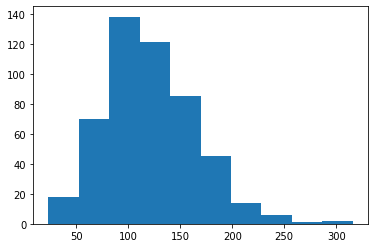

In [ ]:
plt.hist(list_num_tokens, bins=10)
_ = plt.show()

## Data Splitting

In [ ]:
data, labels = [], []
for txt_file, ann_file in zip(txt_files, ann_files):
  text = parse_text(os.path.join(RAW_DATA_DIR, txt_file))
  recs = parse_entity_and_relation(os.path.join(RAW_DATA_DIR, ann_file), text)
  data.extend(recs)
  labels.extend([rec["r"] for rec in recs])

len(data), len(labels)

(6394, 6394)

In [ ]:
data_tv, data_test, labels_tv, labels_test = train_test_split(
    data, labels, stratify=labels, train_size=0.8, random_state=0)
data_train, data_val, labels_train, labels_val = train_test_split(
    data_tv, labels_tv, stratify=labels_tv, train_size=0.9, random_state=0)

len(data_train), len(data_val), len(data_test)

(4603, 512, 1279)

In [ ]:
def compute_rel_mix_frac(data_split):
  ctr = collections.Counter()
  for rec in data_split:
    ctr[rec["r"]] += 1
  kv_dict, tot_v = {}, 0
  for k, v in ctr.most_common(len(ctr)):
    tot_v += v
  for k, v in ctr.most_common(len(ctr)):
    kv_dict[k] = v / tot_v
  return kv_dict


train_reltype_fracs = compute_rel_mix_frac(data_train)
val_reltype_fracs = compute_rel_mix_frac(data_val)
test_reltype_fracs = compute_rel_mix_frac(data_test)
reltypes_df = pd.DataFrame([train_reltype_fracs, val_reltype_fracs, test_reltype_fracs],
                           index=["train", "validation", "test"],
                           columns=sorted(list(set(labels))))
reltypes_df.head()

,COMPARE,CONJUNCTION,COREF,EVALUATE-FOR,FEATURE-OF,HYPONYM-OF,PART-OF,USED-FOR
train,0.036498,0.091028,0.262003,0.071041,0.041277,0.074734,0.042146,0.381273
validation,0.037109,0.091797,0.261719,0.070312,0.041016,0.074219,0.042969,0.380859
test,0.036747,0.091478,0.261923,0.071149,0.041439,0.074277,0.042220,0.380766


## Write out extracted dataset

In [ ]:
def write_data(data, file_path):
  num_written = 0
  with open(file_path, "w") as fout:
    for rec in data:
      fout.write(json.dumps(rec) + "\n")
      num_written += 1
  return num_written

num_train = write_data(data_train, os.path.join(DATA_DIR, "train.jsonl"))
num_val = write_data(data_val, os.path.join(DATA_DIR, "val.jsonl"))
test_val = write_data(data_test, os.path.join(DATA_DIR, "test.jsonl"))

num_train, num_val, test_val

(4603, 512, 1279)